In [2]:
#Import packages and data.

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
root = '/Users/yanglanlan/Desktop/IAQF/co2'
df1=pd.read_csv(root + '/features-weekly.csv',index_col = 'Date', dayfirst = True)
df1

,CO2,Naturalgasfutures
Date,,
2000/8/28,367.70,4.835
2000/9/4,367.32,4.880
2000/9/11,367.33,5.205
2000/9/18,366.86,5.131
2000/9/25,366.86,5.200
...,...,...
2020/12/28,415.33,2.539
2021/1/4,415.38,2.700
2021/1/11,415.07,2.737


# Data Processing

In [3]:
#Recognized the index column as date and drop any missing values.

df1.index = pd.to_datetime(df1.index)
df1.dropna(how='any', inplace=True)
df1

,CO2,Naturalgasfutures
Date,,
2000-08-28,367.70,4.835
2000-09-04,367.32,4.880
2000-09-11,367.33,5.205
2000-09-18,366.86,5.131
2000-09-25,366.86,5.200
...,...,...
2020-12-28,415.33,2.539
2021-01-04,415.38,2.700
2021-01-11,415.07,2.737


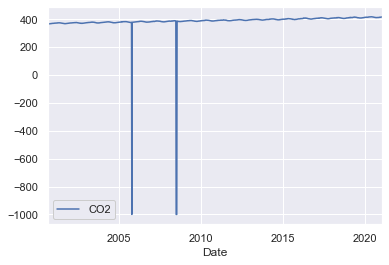

In [5]:
# Plot CO2 graph.

df1['CO2'].plot()
plt.legend(framealpha=1, frameon=True)

# Outliers are observed.

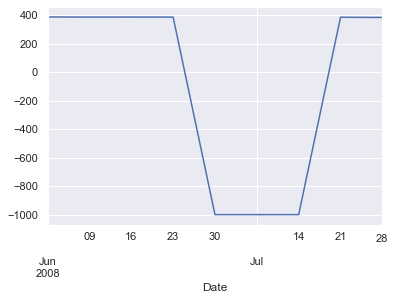

In [7]:
# Identify Outliers.

df1.loc['2008-06-01':'2008-07-31','CO2'].plot()

In [8]:
# Identify second outlier.

df1.loc['2005-10-01':'2005-10-31']

,CO2,Naturalgasfutures
Date,,
2005-10-03,376.83,13.226
2005-10-10,377.10,13.219
2005-10-17,-999.99,12.872
2005-10-24,377.70,13.055
2005-10-31,378.00,11.415


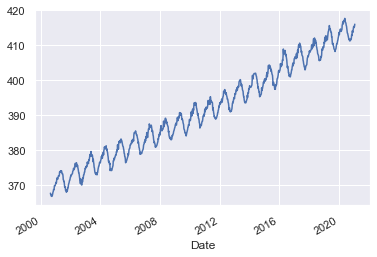

In [9]:
# Remove two outliers.
remove1 = df1.loc['2008-06-29':'2008-07-15']
df1 = df1.drop(remove1.index)
remove2 = df1.loc['2005-10-17':'2005-10-17']
df1 = df1.drop(remove2.index)
df1['CO2'].plot()

#CO2 appears in an upward trend and periodical variation.

# Seasonality Decomposition

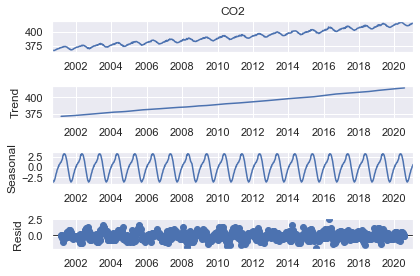

In [12]:
# Identify seasonality, using a frequency of 52 weeks (1 year), additive model (y_observe = trend + seasonality + residual).

result1 = seasonal_decompose(df1['CO2'], model='additive',period = 52)
result1.plot()
pyplot.show()

# Seasonality is obvious.

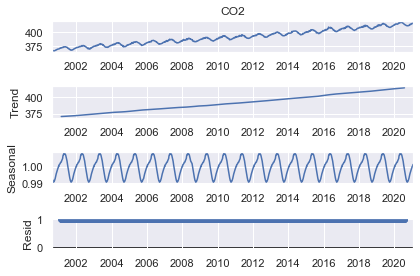

In [13]:
# Check result under multiplicative model (y_observe = trend * seasonality * residual).

result2 = seasonal_decompose(df1['CO2'], model='multiplicative',period = 52)
result2.plot()
pyplot.show()

# Seasonality is still observed, but residual seems a lot quiet.

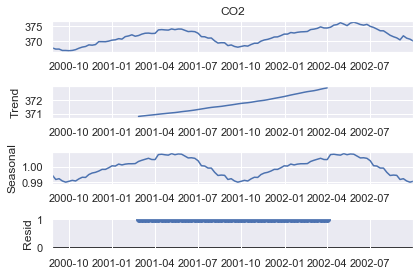

In [14]:
# Take a small portion to see more clearly. Take first two years' data.

t = df1.iloc[:110, :]
result3 = seasonal_decompose(t['CO2'], model='multiplicative')
result3.plot()
pyplot.show()

#CO2 concentration grows in mid-fall, stably climbs and peaks in spring, declines in summer and hits bottom in fall every year.

# Natural Gas VS CO2

In [16]:
# Granger Causality p-value Matrix

import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=15
n_obs=100
X_train, X_test = df1[0:-n_obs], df1[-n_obs:]
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
            
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset

grangers_causality_matrix(df1, variables = df1.columns)

,CO2_x,Naturalgasfutures_x
CO2_y,1.0000,0.0577
Naturalgasfutures_y,0.0047,1.0000


In [19]:
res = grangercausalitytests(df1[['CO2','Naturalgasfutures']],maxlag = 15, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3577  , p=0.5499  , df_denom=1058, df_num=1
ssr based chi2 test:   chi2=0.3587  , p=0.5492  , df=1
likelihood ratio test: chi2=0.3587  , p=0.5492  , df=1
parameter F test:         F=0.3577  , p=0.5499  , df_denom=1058, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5908  , p=0.2043  , df_denom=1055, df_num=2
ssr based chi2 test:   chi2=3.1967  , p=0.2022  , df=2
likelihood ratio test: chi2=3.1919  , p=0.2027  , df=2
parameter F test:         F=1.5908  , p=0.2043  , df_denom=1055, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2919  , p=0.2758  , df_denom=1052, df_num=3
ssr based chi2 test:   chi2=3.9014  , p=0.2723  , df=3
likelihood ratio test: chi2=3.8942  , p=0.2731  , df=3
parameter F test:         F=1.2919  , p=0.2758  , df_denom=1052, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2167  , p=0.